# Convertible Bond Valuation - Convergence Analysis

Value a Convertible Bond using a Tree-Based model that incorporates the conversion option as well as the call and puts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.finutils import *
from financepy.products.bonds import *
from financepy.market.curves import *

###################################################################
# FINANCEPY BETA Version 0.180 - This build: 22 Sep 2020 at 19:38 #
#     This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy #
###################################################################



## Creating the Convertible Bond

We set the maturity date, annualised coupon, coupon frequency and convention for calculating accrued interest

In [3]:
maturityDate = FinDate(20, 3, 2023)
coupon = 0.0
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualBasis = FinDayCountTypes.ACT_365F

We need to set the face amount and the conversion ratio. This is the number of shares you can convert to for that face amount.

In [4]:
face = 100.0 
conversionRatio = 5.0  # Number of shares for face amount

We can also delay the start of the conversion feature using the start convert date

In [5]:
startConvertDate = FinDate(20, 12, 2019)

We can also set the call schedule - the price and date on which the issuer can call back the bond. This is given with reference to a price of 100. Making the call price very high means it will never be called. So the call has no impact.

In [6]:
callPrice = 120 # Make call uneconomic so it does not impact pricing
callDates = [FinDate(20, 3, 2020), FinDate(20, 3, 2021), FinDate(20, 3, 2022)]
callPrices = [callPrice, callPrice, callPrice]

We can also set the put schedule - the price and date on which the owner can put back the bond to the issuer. This is given with reference to a price of 100. Making the put price very low means it will never be put.

In [7]:
putPrice = 0.0 # Make call uneconomic so it does not impact pricing
putDates = [FinDate(20, 3, 2020), FinDate(20, 3, 2021), FinDate(20, 3, 2022)]
putPrices = [putPrice, putPrice, putPrice]

At this point we can create our bond.

In [8]:
bond = FinBondConvertible(maturityDate, coupon, frequencyType, startConvertDate, conversionRatio,
                          callDates, callPrices, putDates, putPrices, accrualBasis, face)

# Valuation

### No Calls and Puts

We need to specify the valuation date

In [9]:
settlementDate = FinDate(31, 12, 2019)

The model allows a discrete dividend schedule. We can use the FinSchedule class to do this.

In [10]:
dividendSchedule = FinSchedule(settlementDate, maturityDate).scheduleDates()[1:]
dividendYields = [0.01] * len(dividendSchedule)

We then need to set up the market inputs. 

In [11]:
stockPrice = 20
stockVolatility = 0.30 # 30 percent
rate = 0.05
discountCurve = FinDiscountCurveFlat(settlementDate, rate, FinFrequencyTypes.ANNUAL)
creditSpread = 0.00
recoveryRate = 0.40 # 40 percent

The model is a binomial tree but you don't need to enter any tree details unless you want to as it defaults to 100 steps per year

We can now peform the valuation

In [12]:
bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
           discountCurve, creditSpread, recoveryRate)

{'cbprice': 109.73979499581712,
 'bond': 85.47634154276028,
 'delta': 2.9871369463337127,
 'gamma': 1.00179669843607,
 'theta': 109.2804662148906}

'cbrice' is the bond price. 'bond' is the price of the bond alone without any conversion and without any puts or calls option

## Impact of Calls

In [13]:
callPrice = 100000.0
callPrices = [callPrice, callPrice, callPrice]

Need to recreate the convertible bond.

In [14]:
bond = FinBondConvertible(maturityDate, coupon, frequencyType, startConvertDate, conversionRatio,
                          callDates, callPrices, putDates, putPrices, accrualBasis, face)

In [15]:
bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
           discountCurve, creditSpread, recoveryRate)

{'cbprice': 111.4339883101883,
 'bond': 85.47634154276028,
 'delta': 3.4293110032941625,
 'gamma': 0.8176586946290804,
 'theta': 125.90967114428429}

## Stock Price Sensitivity

As the stock price goes up, the conversion options becomes more valuable

In [23]:
stockPrices = np.linspace(0,40,11)
print("%9s %12s %12s %12s"% ("StockPx", "CB Price", "Bond Price", "Delta"))

for stockPrice in stockPrices:
    res = bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
                     discountCurve, creditSpread, recoveryRate)
    print("%9.2f %12.4f %12.4f %12.4f"% (stockPrice, res['cbprice'], res['bond'], res['delta']))

  StockPx     CB Price   Bond Price        Delta
     0.00      85.4763      85.4763       0.0000
     4.00      85.4933      85.4763       0.0282
     8.00      86.4131      85.4763       0.5498
    12.00      90.6638      85.4763       1.5943
    16.00      99.2071      85.4763       2.6289
    20.00     111.4340      85.4763       3.4293
    24.00     126.3567      85.4763       3.9902
    28.00     143.1397      85.4763       4.3773
    32.00     161.2975      85.4763       4.6742
    36.00     180.4184      85.4763       4.8708
    40.00     200.0975      85.4763       4.9645


As expected the price rises with increasing stock price as the conversion option is more valuable

## Convergence Testing

Set up the bond description

In [24]:
settlementDate = FinDate(31, 12, 2019)

In [26]:
maturityDate = FinDate(20, 3, 2023)
coupon = 0.0
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualBasis = FinDayCountTypes.ACT_365F

callPrice = 100000.0 # Make call uneconomic so it does not impact pricing
callDates = [] # [FinDate(20, 3, 2020)]
callPrices = [] # [callPrice]

putPrice = 0.0 # Make call uneconomic so it does not impact pricing
putDates = [] # FinDate(20, 3, 2020)]
putPrices = [] # [putPrice]

face = 100.0 
startConvertDate = settlementDate
conversionRatio = 5.0  # Number of shares for face amount

In [27]:
bond = FinBondConvertible(maturityDate, coupon, frequencyType, startConvertDate, conversionRatio,
                          callDates, callPrices, putDates, putPrices, accrualBasis, face)

Set up market

In [29]:
stockPrice = 20.0
stockVolatility = 0.10
rate = 0.05
discountCurve = FinDiscountCurveFlat(settlementDate, rate, FinFrequencyTypes.ANNUAL)
creditSpread = 0.0
recoveryRate = 0.0
dividendSchedule = [] # FinSchedule(settlementDate, maturityDate).flows()[1:]
dividendYields = [] # [0.0] * len(dividendSchedule)

How many tree steps per year do we need to give an accurate price ? Let us check.

In [35]:
stockPrice = 25.0
stockVolatility = 0.30
stepsPerYearList = [100, 200, 400, 1000, 2000, 4000]
cbPrices = []

print("%9s %12s %12s %12s %12s"% ("Steps/Yr", "CB Price", "Bond Price", "Delta","Gamma"))
for numStepsPerYear in stepsPerYearList:
    res = bond.value(settlementDate, stockPrice, stockVolatility, dividendSchedule, dividendYields,
                     discountCurve, creditSpread, recoveryRate, numStepsPerYear)
    print("%9.2f %12.4f %12.4f %12.4f %12.4f"% (numStepsPerYear, res['cbprice'], res['bond'], res['delta'], res['gamma']))
    cbPrices.append(res['cbprice'])

 Steps/Yr     CB Price   Bond Price        Delta        Gamma
   100.00     132.7151      85.4763       4.1752       0.3365
   200.00     132.7112      85.4763       4.1758       0.5087
   400.00     132.7115      85.4763       4.1761       0.7538
  1000.00     132.7084      85.4763       4.1763       1.2411
  2000.00     132.7089      85.4763       4.1763       1.7914
  4000.00     132.7083      85.4763       4.1764       2.5699


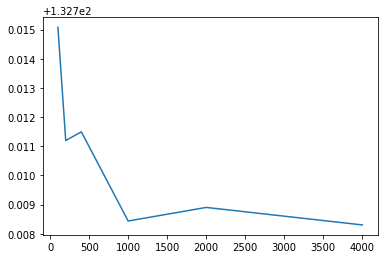

In [51]:
plt.plot(stepsPerYearList,cbPrices);

Copyright (c) 2020 Dominic O'Kane